In [ ]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
!pip install kagglehub
import kagglehub



In [ ]:
# Download the dataset
DATASET_PATH = kagglehub.dataset_download("heartzhacker/medical-imaging")
print("Dataset path:", DATASET_PATH)

# Verify dataset structure
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"Directory: {dirpath}, Files: {len(filenames)}")


100%|██████████| 673M/673M [00:30<00:00, 22.8MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1, Files: 0
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1/Medical-imaging-dataset, Files: 0
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1/Medical-imaging-dataset/Peritonitis, Files: 1000
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1/Medical-imaging-dataset/Ureters, Files: 1000
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1/Medical-imaging-dataset/Diverticulosis, Files: 1000
Directory: /root/.cache/kagglehub/datasets/heartzhacker/medical-imaging/versions/1/Medical-imaging-dataset/Neoplasm, Files: 1000


yaha

In [ ]:
# Define dataset directories
BASE_PATH = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
train_dir = BASE_PATH
val_dir = BASE_PATH

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
# Load DenseNet-121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 795ms/step - accuracy: 0.3694 - loss: 1.6412 - val_accuracy: 0.7575 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 650ms/step - accuracy: 0.6870 - loss: 0.7947 - val_accuracy: 0.8825 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 735ms/step - accuracy: 0.7792 - loss: 0.5984 - val_accuracy: 0.8800 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.8027 - loss: 0.5022 - val_accuracy: 0.8913 - val_loss: 0.3429 - learning_rate: 0.0010
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.8265 - loss: 0.4874 - val_accuracy: 0.8863 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 647ms/step - accuracy: 0.8418 - loss: 0.4299 - val_accuracy: 0.9175 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 643ms/step - accuracy: 0.

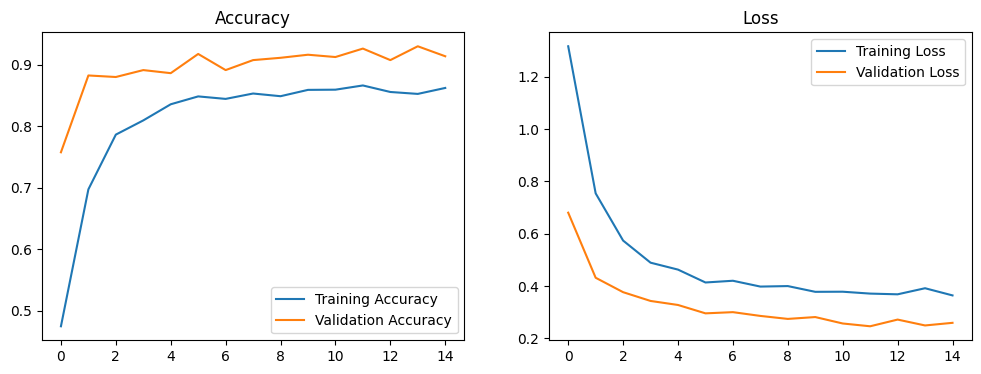

In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)


In [ ]:
# Evaluate model
print("Evaluating model on validation set...")
val_generator.reset()
y_pred_prob = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = val_generator.classes

# Convert ground truth to one-hot encoding for AUC and AUPR
y_true_one_hot = label_binarize(y_true_labels, classes=np.arange(train_generator.num_classes))

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="macro")
recall = recall_score(y_true_labels, y_pred_labels, average="macro")
f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="macro", multi_class="ovr")
aupr = average_precision_score(y_true_one_hot, y_pred_prob, average="macro")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluating model on validation set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step

Evaluation Metrics:
Accuracy: 0.9087
Precision: 0.9085
Recall: 0.9088
F1 Score: 0.9079
AUC: 0.9861
AUPR: 0.9615

Confusion Matrix:
[[198   0   2   0]
 [  2 184   7   7]
 [  7  16 165  12]
 [  5   7   8 180]]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define directories
train_dir = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
val_dir = train_dir  # Assuming a single directory with train-test split handled internally

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Load DenseNet121 as feature extractor
base_model = DenseNet121(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    """
    Extract features using the pre-trained feature extractor.
    """
    features = []
    labels = []
    num_samples = generator.samples
    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * generator.batch_size >= num_samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for training and validation sets
print("Extracting features from training set...")
X_train, y_train = extract_features(train_generator, feature_extractor)

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_generator, feature_extractor)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Extracting features from training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training Random Forest...")
rf.fit(X_train, y_train_labels)


Training Random Forest...


RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Random Forest
y_pred_labels = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)
# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Accuracy: 0.9250
Precision: 0.9251
Recall: 0.9250
F1 Score: 0.9249
AUC: 0.9873
AUPR: 0.9625

Confusion Matrix:
[[196   0   3   1]
 [  2 182   9   7]
 [  1  12 175  12]
 [  0   4   9 187]]


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
print("Training SVM...")
svm.fit(X_train, y_train_labels)


Training SVM...


SVC(probability=True, random_state=42)

In [ ]:
# Evaluate SVM
y_pred_labels = svm.predict(X_val)
y_pred_prob = svm.predict_proba(X_val)

# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


SVM Accuracy: 0.9375
Precision: 0.9384
Recall: 0.9375
F1 Score: 0.9375
AUC: 0.9913
AUPR: 0.9761

Confusion Matrix:
[[195   1   4   0]
 [  0 191   4   5]
 [  0  13 175  12]
 [  0   6   5 189]]


In [ ]:
!pip install scikit-learn==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 70.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import xgboost as xgb
# Convert data to DMatrix, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_labels)
dval = xgb.DMatrix(X_val, label=y_val_labels)

# Define parameters for XGBoost
params = {
    "objective": "multi:softprob",  # Multiclass classification
    "num_class": len(np.unique(y_train_labels)),  # Number of classes
    "max_depth": 6,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
}

# Train the model
print("Training XGBoost...")
model = xgb.train(params, dtrain, num_boost_round=200)



Training XGBoost...


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(dval)

# Get class predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average="macro")
recall = recall_score(y_val_labels, y_pred_labels, average="macro")
f1 = f1_score(y_val_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_val_labels, y_pred_prob, multi_class="ovr")
aupr = average_precision_score(y_val_labels, y_pred_prob, average="macro")

# Confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)


XGBoost Accuracy: 0.9225
Precision: 0.9229
Recall: 0.9225
F1 Score: 0.9224
AUC: 0.9901
AUPR: 0.9734

Confusion Matrix:
[[195   1   2   2]
 [  1 185   8   6]
 [  2  18 171   9]
 [  0   5   8 187]]


In [ ]:
from sklearn.linear_model import LogisticRegression

cnn_clf = LogisticRegression(max_iter=1000, random_state=42)
cnn_clf.fit(X_train, y_train_labels)  # X_train contains DenseNet-extracted features


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Assuming the following variables are preloaded:
# - X_train, y_train_labels: DenseNet features and labels for training
# - X_val, y_val_labels: DenseNet features and labels for validation
# - rf: Pre-trained Random Forest classifier
# - svm: Pre-trained SVM classifier

# ---------------------------
# Voting Classifier
# ---------------------------
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),  # Add DenseNet model

    ],
    voting="soft"  # Soft voting uses predicted probabilities
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train, y_train_labels)




Training Voting Classifier...


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('densenet',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Predictions and Evaluation for Voting Classifier
y_pred_voting = voting_clf.predict(X_val)
y_pred_prob_voting = voting_clf.predict_proba(X_val)

accuracy_voting = accuracy_score(y_val_labels, y_pred_voting)
precision_voting = precision_score(y_val_labels, y_pred_voting, average="macro")
recall_voting = recall_score(y_val_labels, y_pred_voting, average="macro")
f1_voting = f1_score(y_val_labels, y_pred_voting, average="macro")
auc_voting = roc_auc_score(y_val, y_pred_prob_voting, multi_class="ovr")
aupr_voting = average_precision_score(y_val, y_pred_prob_voting, average="macro")
conf_matrix_voting = confusion_matrix(y_val_labels, y_pred_voting)

print("\nVoting Classifier Metrics:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"AUC: {auc_voting:.4f}")
print(f"AUPR: {aupr_voting:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_voting)




Voting Classifier Metrics:
Accuracy: 0.9337
Precision: 0.9341
Recall: 0.9337
F1 Score: 0.9339
AUC: 0.9909
AUPR: 0.9745

Confusion Matrix:
[[195   1   4   0]
 [  1 185   7   7]
 [  0  10 179  11]
 [  0   5   7 188]]


In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),

    ],
    final_estimator=LogisticRegression(),
    stack_method="auto",  # Use default stack method
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train_labels)




Training Stacking Classifier...


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('densenet',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Predictions and Evaluation for Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_val)
y_pred_prob_stacking = stacking_clf.predict_proba(X_val)

accuracy_stacking = accuracy_score(y_val_labels, y_pred_stacking)
precision_stacking = precision_score(y_val_labels, y_pred_stacking, average="macro")
recall_stacking = recall_score(y_val_labels, y_pred_stacking, average="macro")
f1_stacking = f1_score(y_val_labels, y_pred_stacking, average="macro")
auc_stacking = roc_auc_score(y_val, y_pred_prob_stacking, multi_class="ovr")
aupr_stacking = average_precision_score(y_val, y_pred_prob_stacking, average="macro")
conf_matrix_stacking = confusion_matrix(y_val_labels, y_pred_stacking)

print("\nStacking Classifier Metrics:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"AUC: {auc_stacking:.4f}")
print(f"AUPR: {aupr_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)



Stacking Classifier Metrics:
Accuracy: 0.9350
Precision: 0.9353
Recall: 0.9350
F1 Score: 0.9351
AUC: 0.9900
AUPR: 0.9741

Confusion Matrix:
[[196   0   4   0]
 [  1 184   8   7]
 [  0  10 179  11]
 [  0   5   6 189]]


yaha2

In [ ]:
# Define dataset directories
BASE_PATH = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
train_dir = BASE_PATH
val_dir = BASE_PATH

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [ ]:
# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 3600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
# Load DenseNet-121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 116s 838ms/step - accuracy: 0.4029 - loss: 1.5492 - val_accuracy: 0.8300 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 74s 656ms/step - accuracy: 0.7191 - loss: 0.7170 - val_accuracy: 0.8925 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 73s 578ms/step - accuracy: 0.7766 - loss: 0.5614 - val_accuracy: 0.8825 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 591ms/step - accuracy: 0.8261 - loss: 0.4621 - val_accuracy: 0.8775 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 581ms/step - accuracy: 0.8437 - loss: 0.4200 - val_accuracy: 0.9150 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 606ms/step - accuracy: 0.8389 - loss: 0.4211 - val_accuracy: 0.8800 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 571ms/step - accuracy: 0.

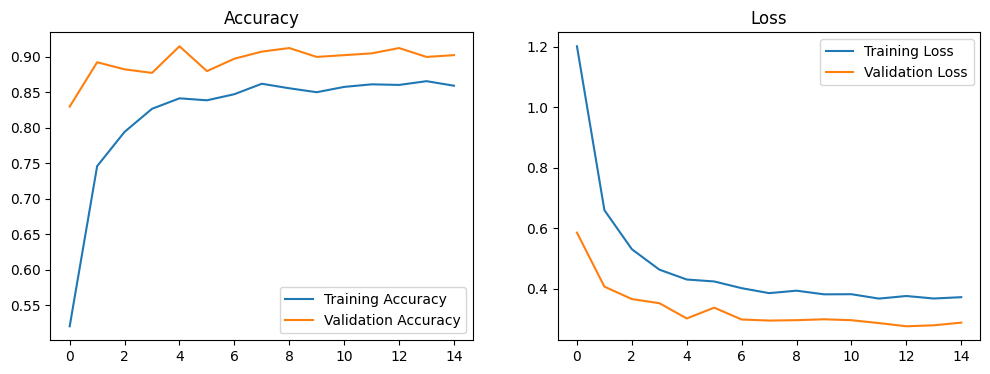

In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)


In [ ]:
# Evaluate model
print("Evaluating model on validation set...")
val_generator.reset()
y_pred_prob = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = val_generator.classes

# Convert ground truth to one-hot encoding for AUC and AUPR
y_true_one_hot = label_binarize(y_true_labels, classes=np.arange(train_generator.num_classes))

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="macro")
recall = recall_score(y_true_labels, y_pred_labels, average="macro")
f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="macro", multi_class="ovr")
aupr = average_precision_score(y_true_one_hot, y_pred_prob, average="macro")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluating model on validation set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step

Evaluation Metrics:
Accuracy: 0.8925
Precision: 0.8946
Recall: 0.8925
F1 Score: 0.8928
AUC: 0.9833
AUPR: 0.9553

Confusion Matrix:
[[94  1  4  1]
 [ 0 94  5  1]
 [ 1 10 83  6]
 [ 1  4  9 86]]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define directories
train_dir = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
val_dir = train_dir  # Assuming a single directory with train-test split handled internally

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Load DenseNet121 as feature extractor
base_model = DenseNet121(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    """
    Extract features using the pre-trained feature extractor.
    """
    features = []
    labels = []
    num_samples = generator.samples
    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * generator.batch_size >= num_samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for training and validation sets
print("Extracting features from training set...")
X_train, y_train = extract_features(train_generator, feature_extractor)

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_generator, feature_extractor)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Extracting features from training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training Random Forest...")
rf.fit(X_train, y_train_labels)


Training Random Forest...


RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Random Forest
y_pred_labels = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)
# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Accuracy: 0.9250
Precision: 0.9251
Recall: 0.9250
F1 Score: 0.9249
AUC: 0.9873
AUPR: 0.9625

Confusion Matrix:
[[196   0   3   1]
 [  2 182   9   7]
 [  1  12 175  12]
 [  0   4   9 187]]


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
print("Training SVM...")
svm.fit(X_train, y_train_labels)


Training SVM...


SVC(probability=True, random_state=42)

In [ ]:
# Evaluate SVM
y_pred_labels = svm.predict(X_val)
y_pred_prob = svm.predict_proba(X_val)

# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


SVM Accuracy: 0.9375
Precision: 0.9384
Recall: 0.9375
F1 Score: 0.9375
AUC: 0.9913
AUPR: 0.9761

Confusion Matrix:
[[195   1   4   0]
 [  0 191   4   5]
 [  0  13 175  12]
 [  0   6   5 189]]


In [ ]:
!pip install scikit-learn==1.0.2

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import xgboost as xgb
# Convert data to DMatrix, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_labels)
dval = xgb.DMatrix(X_val, label=y_val_labels)

# Define parameters for XGBoost
params = {
    "objective": "multi:softprob",  # Multiclass classification
    "num_class": len(np.unique(y_train_labels)),  # Number of classes
    "max_depth": 6,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
}

# Train the model
print("Training XGBoost...")
model = xgb.train(params, dtrain, num_boost_round=200)



Training XGBoost...


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(dval)

# Get class predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average="macro")
recall = recall_score(y_val_labels, y_pred_labels, average="macro")
f1 = f1_score(y_val_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_val_labels, y_pred_prob, multi_class="ovr")
aupr = average_precision_score(y_val_labels, y_pred_prob, average="macro")

# Confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)


XGBoost Accuracy: 0.9225
Precision: 0.9229
Recall: 0.9225
F1 Score: 0.9224
AUC: 0.9901
AUPR: 0.9734

Confusion Matrix:
[[195   1   2   2]
 [  1 185   8   6]
 [  2  18 171   9]
 [  0   5   8 187]]


In [ ]:
from sklearn.linear_model import LogisticRegression

cnn_clf = LogisticRegression(max_iter=1000, random_state=42)
cnn_clf.fit(X_train, y_train_labels)  # X_train contains DenseNet-extracted features


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Assuming the following variables are preloaded:
# - X_train, y_train_labels: DenseNet features and labels for training
# - X_val, y_val_labels: DenseNet features and labels for validation
# - rf: Pre-trained Random Forest classifier
# - svm: Pre-trained SVM classifier

# ---------------------------
# Voting Classifier
# ---------------------------
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),  # Add DenseNet model

    ],
    voting="soft"  # Soft voting uses predicted probabilities
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train, y_train_labels)




Training Voting Classifier...


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('densenet',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Predictions and Evaluation for Voting Classifier
y_pred_voting = voting_clf.predict(X_val)
y_pred_prob_voting = voting_clf.predict_proba(X_val)

accuracy_voting = accuracy_score(y_val_labels, y_pred_voting)
precision_voting = precision_score(y_val_labels, y_pred_voting, average="macro")
recall_voting = recall_score(y_val_labels, y_pred_voting, average="macro")
f1_voting = f1_score(y_val_labels, y_pred_voting, average="macro")
auc_voting = roc_auc_score(y_val, y_pred_prob_voting, multi_class="ovr")
aupr_voting = average_precision_score(y_val, y_pred_prob_voting, average="macro")
conf_matrix_voting = confusion_matrix(y_val_labels, y_pred_voting)

print("\nVoting Classifier Metrics:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"AUC: {auc_voting:.4f}")
print(f"AUPR: {aupr_voting:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_voting)




Voting Classifier Metrics:
Accuracy: 0.9337
Precision: 0.9341
Recall: 0.9337
F1 Score: 0.9339
AUC: 0.9909
AUPR: 0.9745

Confusion Matrix:
[[195   1   4   0]
 [  1 185   7   7]
 [  0  10 179  11]
 [  0   5   7 188]]


In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),

    ],
    final_estimator=LogisticRegression(),
    stack_method="auto",  # Use default stack method
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train_labels)




Training Stacking Classifier...


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('densenet',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Predictions and Evaluation for Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_val)
y_pred_prob_stacking = stacking_clf.predict_proba(X_val)

accuracy_stacking = accuracy_score(y_val_labels, y_pred_stacking)
precision_stacking = precision_score(y_val_labels, y_pred_stacking, average="macro")
recall_stacking = recall_score(y_val_labels, y_pred_stacking, average="macro")
f1_stacking = f1_score(y_val_labels, y_pred_stacking, average="macro")
auc_stacking = roc_auc_score(y_val, y_pred_prob_stacking, multi_class="ovr")
aupr_stacking = average_precision_score(y_val, y_pred_prob_stacking, average="macro")
conf_matrix_stacking = confusion_matrix(y_val_labels, y_pred_stacking)

print("\nStacking Classifier Metrics:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"AUC: {auc_stacking:.4f}")
print(f"AUPR: {aupr_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)



Stacking Classifier Metrics:
Accuracy: 0.9350
Precision: 0.9353
Recall: 0.9350
F1 Score: 0.9351
AUC: 0.9900
AUPR: 0.9741

Confusion Matrix:
[[196   0   4   0]
 [  1 184   8   7]
 [  0  10 179  11]
 [  0   5   6 189]]


yaha3

In [ ]:
# Define dataset directories
BASE_PATH = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
train_dir = BASE_PATH
val_dir = BASE_PATH

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [ ]:
# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 2800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [ ]:
# Load DenseNet-121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3474 - loss: 1.6867 - val_accuracy: 0.7942 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 766ms/step - accuracy: 0.6823 - loss: 0.7890 - val_accuracy: 0.8592 - val_loss: 0.4570 - learning_rate: 0.0010
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 744ms/step - accuracy: 0.7708 - loss: 0.5766 - val_accuracy: 0.8900 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 745ms/step - accuracy: 0.8021 - loss: 0.5227 - val_accuracy: 0.8925 - val_loss: 0.3571 - learning_rate: 0.0010
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 752ms/step - accuracy: 0.8137 - loss: 0.4811 - val_accuracy: 0.8983 - val_loss: 0.3167 - learning_rate: 0.0010
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 747ms/step - accuracy: 0.8414 - loss: 0.4253 - val_accuracy: 0.9075 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 786ms/step - accuracy: 0.8439 - loss: 0.42

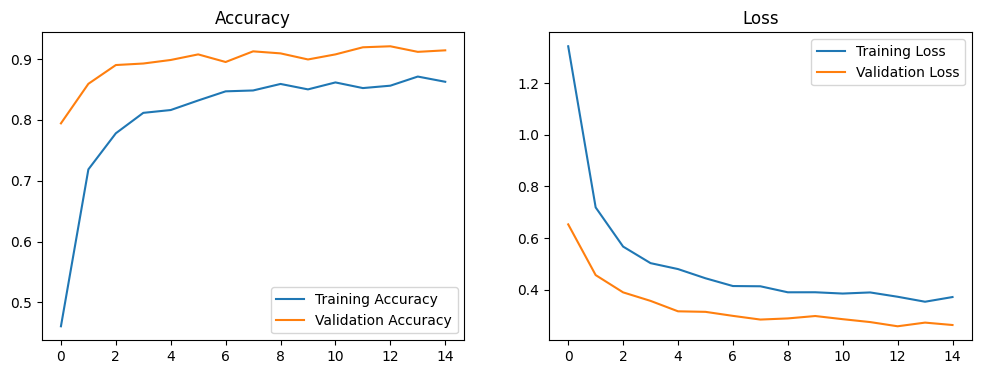

In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)


In [ ]:
# Evaluate model
print("Evaluating model on validation set...")
val_generator.reset()
y_pred_prob = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = val_generator.classes

# Convert ground truth to one-hot encoding for AUC and AUPR
y_true_one_hot = label_binarize(y_true_labels, classes=np.arange(train_generator.num_classes))

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="macro")
recall = recall_score(y_true_labels, y_pred_labels, average="macro")
f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="macro", multi_class="ovr")
aupr = average_precision_score(y_true_one_hot, y_pred_prob, average="macro")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluating model on validation set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step

Evaluation Metrics:
Accuracy: 0.9167
Precision: 0.9181
Recall: 0.9167
F1 Score: 0.9168
AUC: 0.9884
AUPR: 0.9677

Confusion Matrix:
[[289   3   7   1]
 [  1 282   9   8]
 [  4  21 266   9]
 [  1  17  19 263]]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define directories
train_dir = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
val_dir = train_dir  # Assuming a single directory with train-test split handled internally

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Load DenseNet121 as feature extractor
base_model = DenseNet121(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    """
    Extract features using the pre-trained feature extractor.
    """
    features = []
    labels = []
    num_samples = generator.samples
    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * generator.batch_size >= num_samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for training and validation sets
print("Extracting features from training set...")
X_train, y_train = extract_features(train_generator, feature_extractor)

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_generator, feature_extractor)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Extracting features from training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training Random Forest...")
rf.fit(X_train, y_train_labels)


Training Random Forest...


RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Random Forest
y_pred_labels = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)
# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Accuracy: 0.9250
Precision: 0.9251
Recall: 0.9250
F1 Score: 0.9249
AUC: 0.9873
AUPR: 0.9625

Confusion Matrix:
[[196   0   3   1]
 [  2 182   9   7]
 [  1  12 175  12]
 [  0   4   9 187]]


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
print("Training SVM...")
svm.fit(X_train, y_train_labels)


Training SVM...


SVC(probability=True, random_state=42)

In [ ]:
# Evaluate SVM
y_pred_labels = svm.predict(X_val)
y_pred_prob = svm.predict_proba(X_val)

# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


SVM Accuracy: 0.9375
Precision: 0.9384
Recall: 0.9375
F1 Score: 0.9375
AUC: 0.9913
AUPR: 0.9761

Confusion Matrix:
[[195   1   4   0]
 [  0 191   4   5]
 [  0  13 175  12]
 [  0   6   5 189]]


In [ ]:
!pip install scikit-learn==1.0.2

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import xgboost as xgb
# Convert data to DMatrix, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_labels)
dval = xgb.DMatrix(X_val, label=y_val_labels)

# Define parameters for XGBoost
params = {
    "objective": "multi:softprob",  # Multiclass classification
    "num_class": len(np.unique(y_train_labels)),  # Number of classes
    "max_depth": 6,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
}

# Train the model
print("Training XGBoost...")
model = xgb.train(params, dtrain, num_boost_round=200)



Training XGBoost...


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(dval)

# Get class predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average="macro")
recall = recall_score(y_val_labels, y_pred_labels, average="macro")
f1 = f1_score(y_val_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_val_labels, y_pred_prob, multi_class="ovr")
aupr = average_precision_score(y_val_labels, y_pred_prob, average="macro")

# Confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)


XGBoost Accuracy: 0.9225
Precision: 0.9229
Recall: 0.9225
F1 Score: 0.9224
AUC: 0.9901
AUPR: 0.9734

Confusion Matrix:
[[195   1   2   2]
 [  1 185   8   6]
 [  2  18 171   9]
 [  0   5   8 187]]


In [ ]:
from sklearn.linear_model import LogisticRegression

cnn_clf = LogisticRegression(max_iter=1000, random_state=42)
cnn_clf.fit(X_train, y_train_labels)  # X_train contains DenseNet-extracted features


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Assuming the following variables are preloaded:
# - X_train, y_train_labels: DenseNet features and labels for training
# - X_val, y_val_labels: DenseNet features and labels for validation
# - rf: Pre-trained Random Forest classifier
# - svm: Pre-trained SVM classifier

# ---------------------------
# Voting Classifier
# ---------------------------
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),  # Add DenseNet model

    ],
    voting="soft"  # Soft voting uses predicted probabilities
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train, y_train_labels)




Training Voting Classifier...


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('densenet',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Predictions and Evaluation for Voting Classifier
y_pred_voting = voting_clf.predict(X_val)
y_pred_prob_voting = voting_clf.predict_proba(X_val)

accuracy_voting = accuracy_score(y_val_labels, y_pred_voting)
precision_voting = precision_score(y_val_labels, y_pred_voting, average="macro")
recall_voting = recall_score(y_val_labels, y_pred_voting, average="macro")
f1_voting = f1_score(y_val_labels, y_pred_voting, average="macro")
auc_voting = roc_auc_score(y_val, y_pred_prob_voting, multi_class="ovr")
aupr_voting = average_precision_score(y_val, y_pred_prob_voting, average="macro")
conf_matrix_voting = confusion_matrix(y_val_labels, y_pred_voting)

print("\nVoting Classifier Metrics:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"AUC: {auc_voting:.4f}")
print(f"AUPR: {aupr_voting:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_voting)




Voting Classifier Metrics:
Accuracy: 0.9337
Precision: 0.9341
Recall: 0.9337
F1 Score: 0.9339
AUC: 0.9909
AUPR: 0.9745

Confusion Matrix:
[[195   1   4   0]
 [  1 185   7   7]
 [  0  10 179  11]
 [  0   5   7 188]]


In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),

    ],
    final_estimator=LogisticRegression(),
    stack_method="auto",  # Use default stack method
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train_labels)




Training Stacking Classifier...


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('densenet',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Predictions and Evaluation for Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_val)
y_pred_prob_stacking = stacking_clf.predict_proba(X_val)

accuracy_stacking = accuracy_score(y_val_labels, y_pred_stacking)
precision_stacking = precision_score(y_val_labels, y_pred_stacking, average="macro")
recall_stacking = recall_score(y_val_labels, y_pred_stacking, average="macro")
f1_stacking = f1_score(y_val_labels, y_pred_stacking, average="macro")
auc_stacking = roc_auc_score(y_val, y_pred_prob_stacking, multi_class="ovr")
aupr_stacking = average_precision_score(y_val, y_pred_prob_stacking, average="macro")
conf_matrix_stacking = confusion_matrix(y_val_labels, y_pred_stacking)

print("\nStacking Classifier Metrics:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"AUC: {auc_stacking:.4f}")
print(f"AUPR: {aupr_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)



Stacking Classifier Metrics:
Accuracy: 0.9350
Precision: 0.9353
Recall: 0.9350
F1 Score: 0.9351
AUC: 0.9900
AUPR: 0.9741

Confusion Matrix:
[[196   0   4   0]
 [  1 184   8   7]
 [  0  10 179  11]
 [  0   5   6 189]]


yaha4

In [ ]:
# Define dataset directories
BASE_PATH = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
train_dir = BASE_PATH
val_dir = BASE_PATH

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

In [ ]:
# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 2400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


In [ ]:
# Load DenseNet-121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3273 - loss: 1.7590 - val_accuracy: 0.8094 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 887ms/step - accuracy: 0.6271 - loss: 0.8876 - val_accuracy: 0.8719 - val_loss: 0.4808 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7359 - loss: 0.6785 - val_accuracy: 0.8731 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 892ms/step - accuracy: 0.7757 - loss: 0.5753 - val_accuracy: 0.8944 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 893ms/step - accuracy: 0.8192 - loss: 0.4965 - val_accuracy: 0.8925 - val_loss: 0.3442 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 866ms/step - accuracy: 0.8303 - loss: 0.4535 - val_accuracy: 0.9044 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 884ms/step - accuracy: 0.8429 - loss: 0.4257 

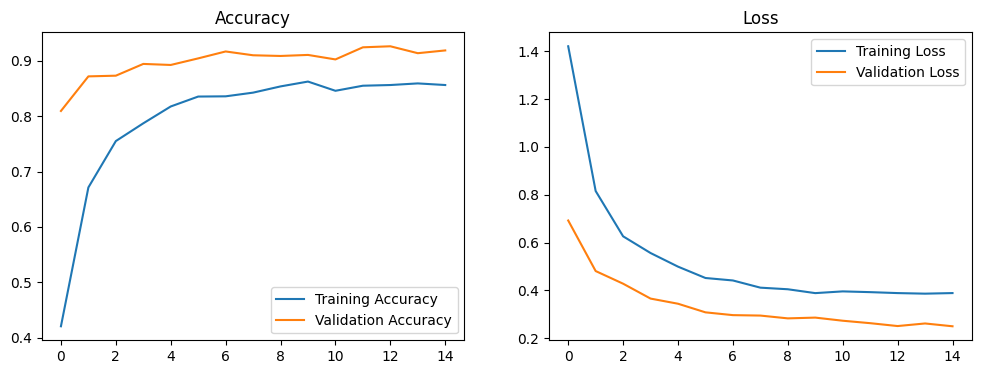

In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)


In [ ]:
# Evaluate model
print("Evaluating model on validation set...")
val_generator.reset()
y_pred_prob = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = val_generator.classes

# Convert ground truth to one-hot encoding for AUC and AUPR
y_true_one_hot = label_binarize(y_true_labels, classes=np.arange(train_generator.num_classes))

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="macro")
recall = recall_score(y_true_labels, y_pred_labels, average="macro")
f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="macro", multi_class="ovr")
aupr = average_precision_score(y_true_one_hot, y_pred_prob, average="macro")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluating model on validation set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 506ms/step

Evaluation Metrics:
Accuracy: 0.9131
Precision: 0.9136
Recall: 0.9131
F1 Score: 0.9133
AUC: 0.9885
AUPR: 0.9695

Confusion Matrix:
[[388   4   8   0]
 [  0 361  24  15]
 [  1  20 351  28]
 [  4  15  20 361]]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define directories
train_dir = os.path.join(DATASET_PATH, "Medical-imaging-dataset")
val_dir = train_dir  # Assuming a single directory with train-test split handled internally

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Load DenseNet121 as feature extractor
base_model = DenseNet121(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    """
    Extract features using the pre-trained feature extractor.
    """
    features = []
    labels = []
    num_samples = generator.samples
    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * generator.batch_size >= num_samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for training and validation sets
print("Extracting features from training set...")
X_train, y_train = extract_features(train_generator, feature_extractor)

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_generator, feature_extractor)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Extracting features from training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training Random Forest...")
rf.fit(X_train, y_train_labels)


Training Random Forest...


RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Random Forest
y_pred_labels = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)
# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Accuracy: 0.9250
Precision: 0.9251
Recall: 0.9250
F1 Score: 0.9249
AUC: 0.9873
AUPR: 0.9625

Confusion Matrix:
[[196   0   3   1]
 [  2 182   9   7]
 [  1  12 175  12]
 [  0   4   9 187]]


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
print("Training SVM...")
svm.fit(X_train, y_train_labels)


Training SVM...


SVC(probability=True, random_state=42)

In [ ]:
# Evaluate SVM
y_pred_labels = svm.predict(X_val)
y_pred_prob = svm.predict_proba(X_val)

# Metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
aupr = average_precision_score(y_val, y_pred_prob, average='weighted')
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Print Metrics
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


SVM Accuracy: 0.9375
Precision: 0.9384
Recall: 0.9375
F1 Score: 0.9375
AUC: 0.9913
AUPR: 0.9761

Confusion Matrix:
[[195   1   4   0]
 [  0 191   4   5]
 [  0  13 175  12]
 [  0   6   5 189]]


In [ ]:
!pip install scikit-learn==1.0.2

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import xgboost as xgb
# Convert data to DMatrix, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_labels)
dval = xgb.DMatrix(X_val, label=y_val_labels)

# Define parameters for XGBoost
params = {
    "objective": "multi:softprob",  # Multiclass classification
    "num_class": len(np.unique(y_train_labels)),  # Number of classes
    "max_depth": 6,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
}

# Train the model
print("Training XGBoost...")
model = xgb.train(params, dtrain, num_boost_round=200)



Training XGBoost...


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(dval)

# Get class predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_labels, y_pred_labels)
precision = precision_score(y_val_labels, y_pred_labels, average="macro")
recall = recall_score(y_val_labels, y_pred_labels, average="macro")
f1 = f1_score(y_val_labels, y_pred_labels, average="macro")
auc = roc_auc_score(y_val_labels, y_pred_prob, multi_class="ovr")
aupr = average_precision_score(y_val_labels, y_pred_prob, average="macro")

# Confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"AUPR: {aupr:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)


XGBoost Accuracy: 0.9225
Precision: 0.9229
Recall: 0.9225
F1 Score: 0.9224
AUC: 0.9901
AUPR: 0.9734

Confusion Matrix:
[[195   1   2   2]
 [  1 185   8   6]
 [  2  18 171   9]
 [  0   5   8 187]]


In [ ]:
from sklearn.linear_model import LogisticRegression

cnn_clf = LogisticRegression(max_iter=1000, random_state=42)
cnn_clf.fit(X_train, y_train_labels)  # X_train contains DenseNet-extracted features


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Assuming the following variables are preloaded:
# - X_train, y_train_labels: DenseNet features and labels for training
# - X_val, y_val_labels: DenseNet features and labels for validation
# - rf: Pre-trained Random Forest classifier
# - svm: Pre-trained SVM classifier

# ---------------------------
# Voting Classifier
# ---------------------------
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),  # Add DenseNet model

    ],
    voting="soft"  # Soft voting uses predicted probabilities
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train, y_train_labels)




Training Voting Classifier...


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('densenet',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Predictions and Evaluation for Voting Classifier
y_pred_voting = voting_clf.predict(X_val)
y_pred_prob_voting = voting_clf.predict_proba(X_val)

accuracy_voting = accuracy_score(y_val_labels, y_pred_voting)
precision_voting = precision_score(y_val_labels, y_pred_voting, average="macro")
recall_voting = recall_score(y_val_labels, y_pred_voting, average="macro")
f1_voting = f1_score(y_val_labels, y_pred_voting, average="macro")
auc_voting = roc_auc_score(y_val, y_pred_prob_voting, multi_class="ovr")
aupr_voting = average_precision_score(y_val, y_pred_prob_voting, average="macro")
conf_matrix_voting = confusion_matrix(y_val_labels, y_pred_voting)

print("\nVoting Classifier Metrics:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"AUC: {auc_voting:.4f}")
print(f"AUPR: {aupr_voting:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_voting)




Voting Classifier Metrics:
Accuracy: 0.9337
Precision: 0.9341
Recall: 0.9337
F1 Score: 0.9339
AUC: 0.9909
AUPR: 0.9745

Confusion Matrix:
[[195   1   4   0]
 [  1 185   7   7]
 [  0  10 179  11]
 [  0   5   7 188]]


In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("densenet", cnn_clf),

    ],
    final_estimator=LogisticRegression(),
    stack_method="auto",  # Use default stack method
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train_labels)




Training Stacking Classifier...


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('densenet',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Predictions and Evaluation for Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_val)
y_pred_prob_stacking = stacking_clf.predict_proba(X_val)

accuracy_stacking = accuracy_score(y_val_labels, y_pred_stacking)
precision_stacking = precision_score(y_val_labels, y_pred_stacking, average="macro")
recall_stacking = recall_score(y_val_labels, y_pred_stacking, average="macro")
f1_stacking = f1_score(y_val_labels, y_pred_stacking, average="macro")
auc_stacking = roc_auc_score(y_val, y_pred_prob_stacking, multi_class="ovr")
aupr_stacking = average_precision_score(y_val, y_pred_prob_stacking, average="macro")
conf_matrix_stacking = confusion_matrix(y_val_labels, y_pred_stacking)

print("\nStacking Classifier Metrics:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"AUC: {auc_stacking:.4f}")
print(f"AUPR: {aupr_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)



Stacking Classifier Metrics:
Accuracy: 0.9350
Precision: 0.9353
Recall: 0.9350
F1 Score: 0.9351
AUC: 0.9900
AUPR: 0.9741

Confusion Matrix:
[[196   0   4   0]
 [  1 184   8   7]
 [  0  10 179  11]
 [  0   5   6 189]]
